# Example 1: The Refined Weak Coupling/ Cumulant equation for a spin boson model with an overdamped spectral density

This example provides the necessary code to reproduce the calculations from [1](https://arxiv.org/abs/2403.04488), where the Hamiltonian of the spin-boson model is given by

\begin{align}
     H = \underbrace{\frac{\omega_{0}}{2} \sigma_{z}}_{H_S} + \underbrace{\sum_{k} w_{k} a_{k}^{\dagger} a_{k}}_{H_B} + \underbrace{\sum_{k} g_k (f_1 \sigma_{x}+f_2 \sigma_{y} +f_3 \sigma_{z}) (a_{k}+a_{k}^{\dagger})}_{H_I}
\end{align}

We first begin by importing the necessary packages

In [1]:
from nmm import csolve,OverdampedBath
from qutip import Qobj,sigmaz,sigmax,brmesolve,heom,DrudeLorentzEnvironment
import numpy as np
from scipy.integrate import quad_vec
from scipy import linalg
from tqdm import tqdm
import matplotlib.pyplot as plt

We now specify the parameters of our simulation

In [2]:
w0 = 1
alpha = 0.05
gamma = 5*w0
T = 1*w0
tf = 80
t=np.linspace(0,tf,100)
Hsys = sigmaz()/2
Q = sigmax()

The refined weak coupling or cumulant equation needs the spectral density to
calculate the decay rates, to make simulation easy we included the spectral 
densities among other bath related functions in bath classes, in this example
we want to use a Drude Lorentz overdamped spectral density, so we initialize an 
OverdampedBath

In [3]:
bath=DrudeLorentzEnvironment(T,alpha,gamma)

Next we initialize the csolve which is the solver of the cumulant equation, it
requires the time grid for our simulation, the system Hamiltonian, The coupling
operator $Q$, andd the bath object

In [4]:
cc = csolve(Hsys,t ,[bath], [Q],cython=False)

We now specify our inital state

In [5]:
rho0=0.5*Qobj([[1,1],[1,1]])
rho0

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]

We now simply obtain the evolution using the cumulant equation

In [6]:
result=cc.evolution(rho0)

Calculating time dependent generators: 100%|██████████| 4/4 [00:00<00:00, 1338.11it/s]
Computing Exponential of Generators . . . .: 100it [00:00, 2658.21it/s]


The evolution of the cumulant equation is given in the interaction picture, to get it in the Schrodinger picture a rotation is needed

In [7]:
def rotation(data,H, t):
    try:
        rotated = [
            (-1j * H * t[i]).expm()
            * data[i]
            * (1j * H * t[i]).expm()
            for i in range(len(t))
        ]
    except:
        rotated = [
            (-1j * H * t[i]).expm()
            * qt.Qobj(data[i],dims=H.dims)
            * (1j * H * t[i]).expm()
            for i in range(len(t))
        ]
    return rotated

In [8]:
result=rotation(result,Hsys,t)


We know solve the same system with the Hierarchical Equations of motion (HEOM)
we use Qutip's implementation. Details can be found 
[here](https://qutip.org/docs/latest/guide/guide-heom.html)

In [9]:
bathh = bath.approximate('pade',Nk=4)
result_h = heom.heomsolve(Hsys, [bathh,Q], 3,rho0,t)

10.1%. Run time:   0.04s. Est. time left: 00:00:00:00
20.2%. Run time:   0.08s. Est. time left: 00:00:00:00
30.3%. Run time:   0.11s. Est. time left: 00:00:00:00
40.4%. Run time:   0.14s. Est. time left: 00:00:00:00
50.5%. Run time:   0.18s. Est. time left: 00:00:00:00
60.6%. Run time:   0.21s. Est. time left: 00:00:00:00
70.7%. Run time:   0.24s. Est. time left: 00:00:00:00
80.8%. Run time:   0.28s. Est. time left: 00:00:00:00
90.9%. Run time:   0.31s. Est. time left: 00:00:00:00
100.0%. Run time:   0.34s. Est. time left: 00:00:00:00
Total run time:   0.34s


and finally let us use the Bloch-Redfield equation which uses a similar level 
of approximation as the Refined Weak Coupling/Cumulant Equation

In [10]:
a_ops = [[Q, bath]]
resultBR = brmesolve(Hsys, rho0, t, a_ops=a_ops,sec_cutoff=-1)

In [11]:
#Auxiliary function for plotting
def population(den, a, b):
    return [den[i][a, b] for i in range(len(den))]

/home/gerardo/.pyenv/versions/3.13.0/envs/qutip-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/gerardo/.pyenv/versions/3.13.0/envs/qutip-dev/lib/python3.13/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


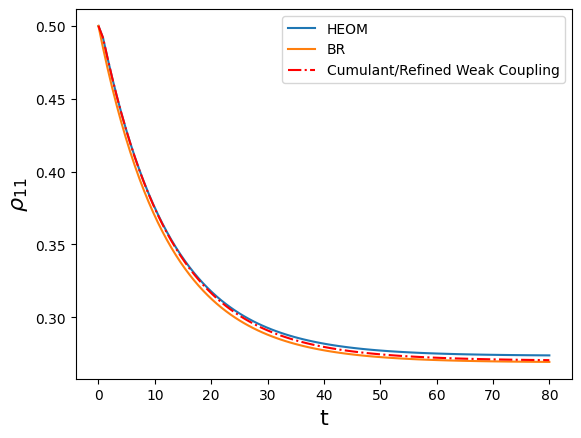

In [12]:
plt.plot(t,population(result_h.states,0,0),label='HEOM')
plt.plot(t,population(resultBR.states,0,0),label='BR')
plt.plot(t,population(result,0,0),'r-.',label='Cumulant/Refined Weak Coupling')
plt.ylabel(r'$\rho_{11}$',fontsize=16)
plt.xlabel(r't',fontsize=16)
plt.legend()
plt.show()

### Let us compare with the semi-analytical form of the cumulant/refined weak coupling for a qubit from  [1](https://arxiv.org/abs/2403.04488)

In [13]:
def bose(ν, T):
    if T == 0:
        return 0
    if ν == 0:
        return 0
    return np.exp(-ν / T) / (1-np.exp(-ν / T))


def spectral_density(w, lam, gamma):
    return 2 * w * lam * gamma / (gamma**2 + w**2)/np.pi


def γ(ν, w, w1, T, t, gamma, lam):
    var = (
        t * t * np.exp(1j * (w - w1) / 2 * t) *
        spectral_density(ν, lam, gamma) *
        (np.sinc((w - ν) / (2 * np.pi) * t) * np.sinc((w1 - ν) / (2 * np.pi) * t)) *
        (bose(ν, T) + 1))
    var += (
        t
        * t
        * np.exp(1j * (w - w1) / 2 * t)
        * spectral_density(ν, lam, gamma)
        * (np.sinc((w + ν) / (2 * np.pi) * t) * np.sinc((w1 + ν) / (2 * np.pi) * t))
        * bose(ν, T)
    )
    return var


def Γplus(w, T, t, wc, lam, ϵ): return quad_vec(
    lambda ν: γ(ν, w, w, T, t, wc, lam),
    0,
    np.inf,
    epsabs=ϵ,
    epsrel=ϵ,
    quadrature="gk15",
)[0]


def Γminus(w, T, t, wc, lam, ϵ): return quad_vec(
    lambda ν: γ(ν, -w, -w, T, t, wc, lam),
    0,
    np.inf,
    quadrature="gk15",
    epsabs=ϵ,
    epsrel=ϵ,
)[0]


def Γplusminus(w, T, t, wc, lam, ϵ): return quad_vec(
    lambda ν: γ(ν, w, -w, T, t, wc, lam),
    0,
    np.inf,
    epsabs=ϵ,
    epsrel=ϵ,
)[0]


def Γzplus(w, T, t, wc, lam, ϵ): return quad_vec(
    lambda ν: γ(ν, 0, w, T, t, wc, lam),
    0,
    np.inf,
    quadrature="gk21",
    epsabs=ϵ,
    epsrel=ϵ,
)[0]


def Γzminus(w, T, t, wc, lam, ϵ): return quad_vec(
    lambda ν: γ(ν, 0, -w, T, t, wc, lam),
    0,
    np.inf,
    quadrature="gk21",
    epsabs=ϵ,
    epsrel=ϵ,
)[0]


def Γzz(w, T, t, wc, lam, ϵ): return quad_vec(
    lambda ν: γ(ν, 0, 0, T, t, wc, lam),
    0,
    np.inf,
    quadrature="gk21",
    epsabs=ϵ,
    epsrel=ϵ,
)[0]



def M(w, T, lam, t, f1, f2, f3, wc, ϵ):
    f = f1 - 1j * f2
    gplus = (np.abs(f) ** 2) * Γplus(w, T, t, wc, lam, ϵ)
    gminus = (np.abs(f) ** 2) * Γminus(w, T, t, wc, lam, ϵ)
    gzplus = np.conjugate(f) * f3 * Γzplus(w, T, t, wc, lam, ϵ)
    gzminus = f * f3 * Γzminus(w, T, t, wc, lam, ϵ)
    gamma = gplus + gminus
    l = np.conjugate(gzplus) + gzminus
    A = np.conjugate(gzplus) - gzminus
    plusminus = f**2 * Γplusminus(w, T, t, wc, lam, ϵ)
    gammazz = 2 * f3**2 * Γzz(w, T, t, wc, lam, ϵ)
    xiz = 0  # These are included to show the full matrix as in 1
    xi = 0  # but LS corrections are not included here
    matriz = np.array(
        [
            [-gamma, xiz * f2 + np.real(l), -xiz * f1 - np.imag(l)],
            [
                np.real(l) - f2 * xiz,
                np.real(plusminus) - (gamma / 2) - gammazz,
                -xi - np.imag(plusminus),
            ],
            [
                -np.imag(l) + f1 * xiz,
                xi - np.imag(plusminus),
                - np.real(plusminus) - (gamma / 2) - gammazz,
            ],
        ]
    )
    r = [
        (gminus - gplus) / 2,
        np.real(A),
        -np.imag(A),
    ]
    return matriz, r


def dynamics(w, T, t, lam, f1, f2, f3, wc, ϵ, a):
    s1 = np.array([[0, 1], [1, 0]])
    s2 = np.array([[0, -1j], [1j, 0]])
    s3 = np.array([[1, 0], [0, -1]])
    if t == 0:
        return (np.eye(2) / 2) + a[0] * s3 + a[2] * s2 + a[1] * s1
    m, r = M(w, T, lam, t, f1, f2, f3, wc, ϵ)
    if (f1 == f2) & (f2 == 0):
        m = m[1:, 1:]
        # print(m.shape)
        exponential = linalg.expm(m)
        pauli_coeff = (exponential - np.eye(2)) @ np.linalg.inv(m) @ r[1:]
        with_pauli = pauli_coeff[0] * s1 + pauli_coeff[1] * s2
        transient = exponential @ a[1:]
        transient_base = transient[0] * s1 + transient[1] * s2
        total = (np.eye(2) / 2) + transient_base + with_pauli + a[0] * s3
        return total
    exponential = linalg.expm(m)
    pauli_coeff = (exponential - np.eye(3)) @ np.linalg.inv(m) @ r
    with_pauli = pauli_coeff[0] * s3 + pauli_coeff[1] * s1 + pauli_coeff[2] * s2
    transient = exponential @ a
    transient_base = transient[0] * s3 + transient[1] * s1 + transient[2] * s2
    total = (np.eye(2) / 2) + transient_base + with_pauli
    return total

def rotation(data, t):
    sz = np.array([[1, 0], [0, -1]])
    rotated = [
        linalg.expm(-(1j * sz / 2) * t[i])
        @ np.array(data)[i]
        @ linalg.expm((1j * sz / 2) * t[i])
        for i in tqdm(range(len(t)), desc=f"Computing for all t, currently on ")
    ]
    return rotated

def cumulant(
    t, w, T, lam, f1, f2, f3, a, b, c, gamma, ϵ, dm=True, l=10, t0=0
):
    t = np.linspace(t0, t, l)
    data = [
        dynamics(w, T, i, lam, f1, f2, f3, gamma, ϵ, [a, b, c])
        for i in tqdm(t, desc=f"Computing for all t, currently on ")
    ]
    data = rotation(data, t)
    if dm:
        return data
    ρ11 = np.array([data[i][0, 0] for i in range(len(data))])
    ρ12 = np.array([data[i][0, 1] for i in range(len(data))])
    ρ21 = np.array([data[i][1, 0] for i in range(len(data))])
    ρ22 = np.array([data[i][1, 1] for i in range(len(data))])
    return ρ11, ρ12, ρ21, ρ22

In [14]:
cum2=cumulant(t[-1],w0,T,alpha,1,0,0,0,0.5,0,gamma,1e-3)

Computing for all t, currently on : 100%|██████████| 10/10 [00:00<00:00, 9738.34it/s]


/home/gerardo/.pyenv/versions/3.13.0/envs/qutip-dev/lib/python3.13/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


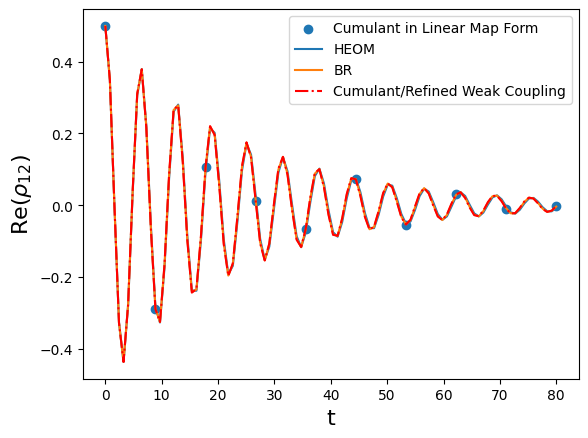

In [15]:
t2=np.linspace(0,t[-1],len(cum2))
plt.scatter(t2,population(cum2,0,1),label='Cumulant in Linear Map Form')
plt.plot(t,population(result_h.states,0,1),label='HEOM')
plt.plot(t,population(resultBR.states,0,1),label='BR')
plt.plot(t,population(result,0,1),'r-.',label='Cumulant/Refined Weak Coupling')
plt.ylabel(r'Re($\rho_{12}$)',fontsize=16)
plt.xlabel(r't',fontsize=16)
plt.legend()
plt.show()

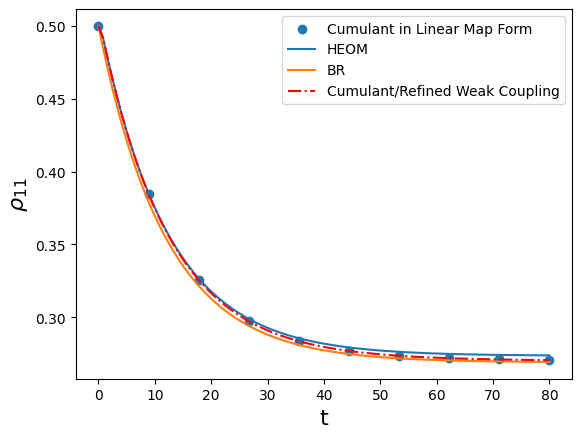

In [16]:
plt.scatter(t2,population(cum2,0,0),label='Cumulant in Linear Map Form')
plt.plot(t,population(result_h.states,0,0),label='HEOM')
plt.plot(t,population(resultBR.states,0,0),label='BR')
plt.plot(t,population(result,0,0),'r-.',label='Cumulant/Refined Weak Coupling')
plt.ylabel(r'$\rho_{11}$',fontsize=16)
plt.xlabel(r't',fontsize=16)
plt.legend()
plt.show()